In [2]:
import numpy as np
import os
CurrentPath = os.getcwd()
data_1 = np.loadtxt(CurrentPath + '/2025/data_1.txt', delimiter=' ')
X = data_1.T[0];Y = data_1.T[1]; var = data_1.T[2]

In [24]:
import nestle

#define loglikelihood
def loglike_linear(theta):
    model = linear(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

#define models
def linear(x, theta):
    y= theta[0]*x + theta[1]
    return y
def cube(x,theta):
    y = theta[0]*x**3 + theta[1]*x**2 + theta[2]*x + theta[3]
    return y
def quadratic(x,theta):
    y = theta[0]*x**2 + theta[1]*x + theta[2]
    return y
def exponential(x,theta):
    y = theta[0]*np.exp(theta[1]*x) + theta[2]
    return y
def powerlaw(x,theta):
    y = theta[0]*x**theta[1] + theta[2]
    return y
#define prior
def prior(x):
    theta = 200 * x - 100
    return theta

### linear function

In [7]:
import matplotlib.pyplot as plt
import corner


result_linear = nestle.sample(loglike_linear, prior, 2,npoints=1000, method='single')
print(result_linear.summary(), f"\nlogzerr: {result_linear.logzerr}")
p_linear, cov_linear = nestle.mean_and_cov(result_linear.samples, result_linear.weights)
print(f"Best-fit parameters: a = {p_linear[0]:.3f} +/- {np.sqrt(cov_linear[0,0]):.3f}")
print(f"Best-fit parameters: b = {p_linear[1]:.3f} +/- {np.sqrt(cov_linear[1,1]):.3f}")

plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, linear(X, p_linear), label='Best-fit linear model')
plt.text(0.1,13, f"y = {p_linear[0]:.3f}x + {p_linear[1]:.3f}")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
fig = corner.corner(result_linear.samples,weights=result_linear.weights, labels=['a', 'b'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

KeyboardInterrupt: 

### quadratic func

In [25]:
#define prior
"""
def prior(x):
    theta = np.array([1,300,300]) * x + np.array([400,-200,-200])
    return theta
"""
def loglike_quadratic(theta):
    model = quadratic(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_quadratic = nestle.sample(loglike_quadratic, prior, 3,npoints=1000, method='single')
print(result_quadratic.summary(), f"\nlogzerr: {result_quadratic.logzerr}")
p_quadratic, cov_quadratic = nestle.mean_and_cov(result_quadratic.samples, result_quadratic.weights)
print(f"Best-fit parameters: {p_quadratic[0]:.3f} +/- {np.sqrt(cov_quadratic[0,0]):.3f}")
print(f"Best-fit parameters: {p_quadratic[1]:.3f} +/- {np.sqrt(cov_quadratic[1,1]):.3f}")
print(f"Best-fit parameters: {p_quadratic[2]:.3f} +/- {np.sqrt(cov_quadratic[2,2]):.3f}")

plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, quadratic(X, p_quadratic), label='Best-fit quad model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_quadratic[0]:.3f}x^2 + {p_quadratic[1]:.3f}x + {p_quadratic[2]:.3f}")
plt.legend()
fig = corner.corner(result_quadratic.samples,weights=result_quadratic.weights, labels=['a', 'b','c'],
                    range=[0.99999, 0.99999,0.99999], bins=30)
plt.show()

KeyboardInterrupt: 

### cubic function

niter: 16477
ncall: 32970
nsamples: 17477
logz: -18.422 +/-  0.118
h: 13.825 
logzerr: 0.11757874200142714
Best-fit parameters: 1.274 +/- 6.421
Best-fit parameters: 9.695 +/- 9.476
Best-fit parameters: 2.702 +/- 4.013
Best-fit parameters: 4.607 +/- 0.476


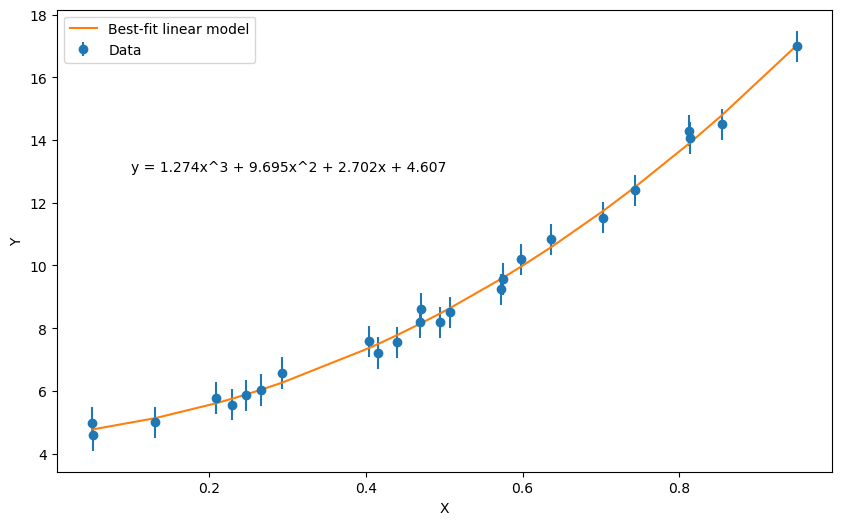

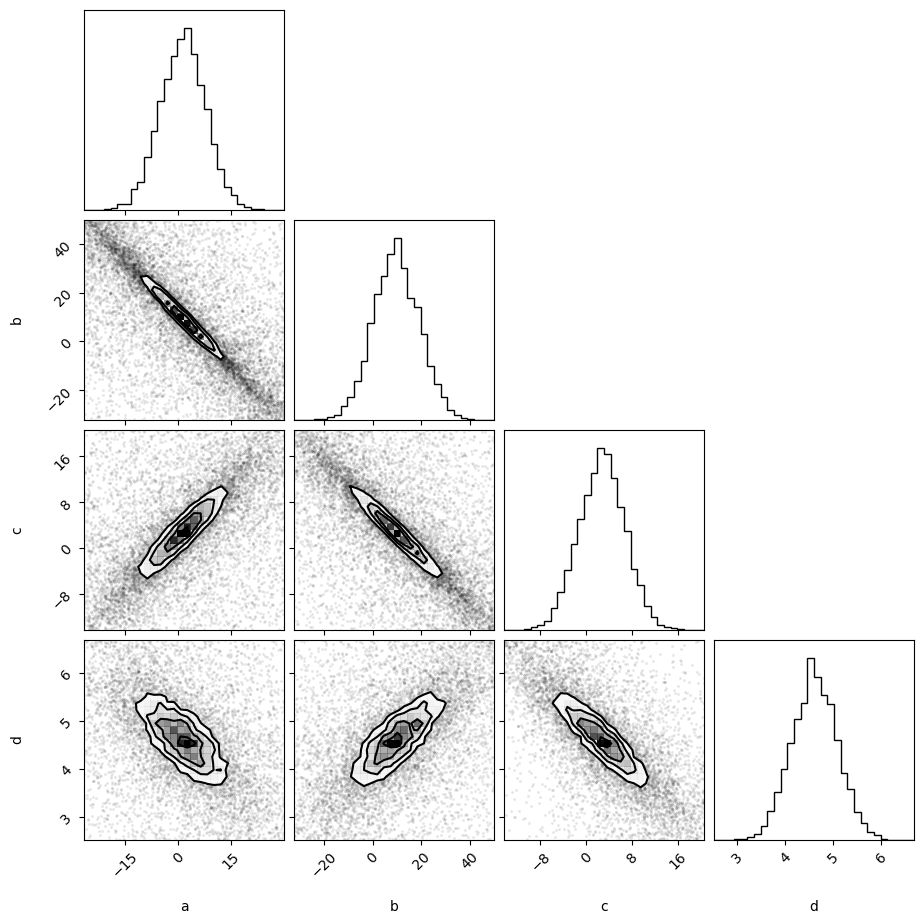

In [13]:
def loglike_cube(theta):
    model = cube(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_cube = nestle.sample(loglike_cube, prior, 4,npoints=1000, method='single')
print(result_cube.summary(), f"\nlogzerr: {result_cube.logzerr}")
p_cube, cov_cube = nestle.mean_and_cov(result_cube.samples, result_cube.weights)
print(f"Best-fit parameters: {p_cube[0]:.3f} +/- {np.sqrt(cov_cube[0,0]):.3f}")
print(f"Best-fit parameters: {p_cube[1]:.3f} +/- {np.sqrt(cov_cube[1,1]):.3f}")
print(f"Best-fit parameters: {p_cube[2]:.3f} +/- {np.sqrt(cov_cube[2,2]):.3f}")
print(f"Best-fit parameters: {p_cube[3]:.3f} +/- {np.sqrt(cov_cube[3,3]):.3f}")



plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, cube(X, p_cube), label='Best-fit linear model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_cube[0]:.3f}x^3 + {p_cube[1]:.3f}x^2 + {p_cube[2]:.3f}x + {p_cube[3]:.3f}")
plt.legend()

fig = corner.corner(result_cube.samples,weights=result_cube.weights, labels=['a', 'b','c','d'],
                    range=[0.99999, 0.99999,0.99999,0.99999], bins=30)
plt.show()

### exponential function

niter: 17855
ncall: 1559271
nsamples: 18855
logz: -20.048 +/-  0.125
h: 15.559 
logzerr: 0.12473601886424393
Best-fit parameters: 3.534 +/- 1.044
Best-fit parameters: 1.655 +/- 0.236
Best-fit parameters: 0.714 +/- 1.272


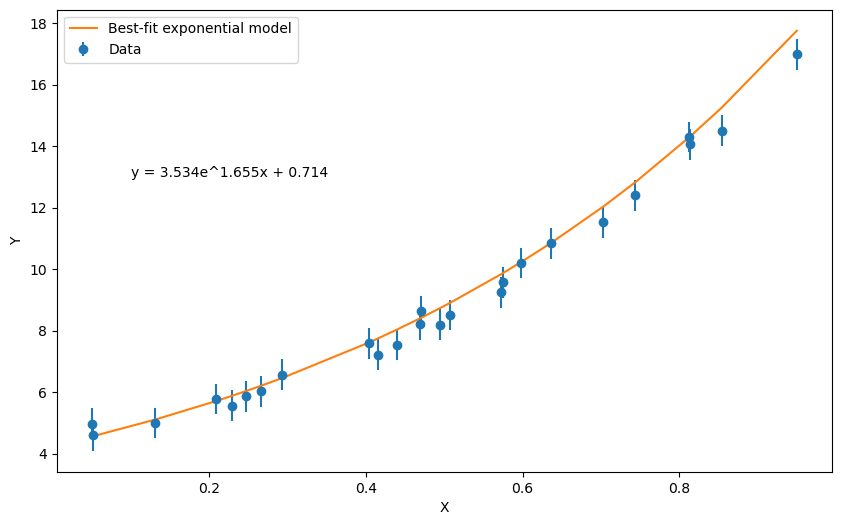

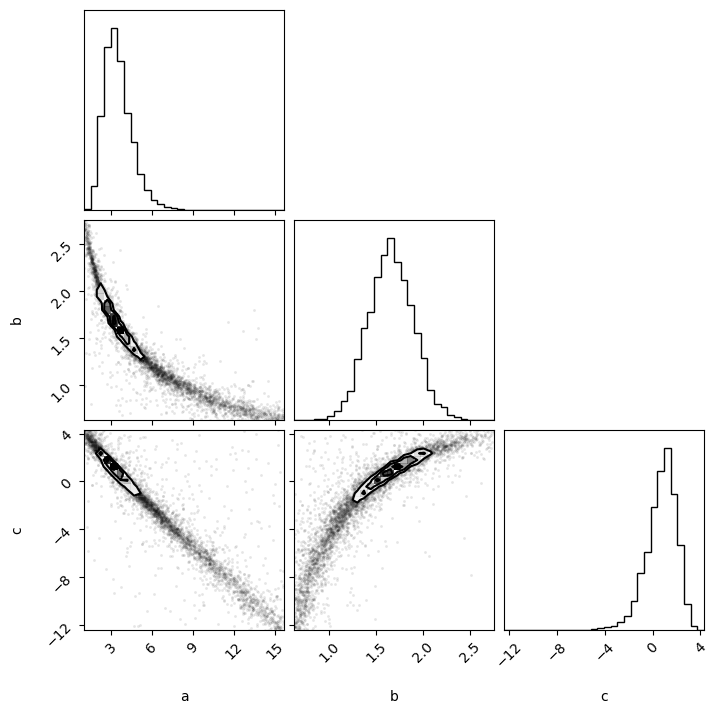

In [14]:
def loglike_exponential(theta):
    model = exponential(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_exponential = nestle.sample(loglike_exponential, prior, 3,npoints=1000, method='single')
print(result_exponential.summary(), f"\nlogzerr: {result_exponential.logzerr}")
p_exponential, cov_exponential = nestle.mean_and_cov(result_exponential.samples, result_exponential.weights)
print(f"Best-fit parameters: {p_exponential[0]:.3f} +/- {np.sqrt(cov_exponential[0,0]):.3f}")
print(f"Best-fit parameters: {p_exponential[1]:.3f} +/- {np.sqrt(cov_exponential[1,1]):.3f}")
print(f"Best-fit parameters: {p_exponential[2]:.3f} +/- {np.sqrt(cov_exponential[2,2]):.3f}")



plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, exponential(X, p_exponential), label='Best-fit exponential model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_exponential[0]:.3f}e^{p_exponential[1]:.3f}x + {p_exponential[2]:.3f}")
plt.legend()

fig = corner.corner(result_exponential.samples,weights=result_exponential.weights, labels=['a', 'b','c'],
                    range=[0.99999, 0.99999,0.99999], bins=30)
plt.show()


### Power law

niter: 17136
ncall: 935330
nsamples: 18136
logz: -19.058 +/-  0.122
h: 14.834 
logzerr: 0.12179589937417415
Best-fit parameters: 13.335 +/- 0.416
Best-fit parameters: 1.847 +/- 0.135
Best-fit parameters: 4.816 +/- 0.266


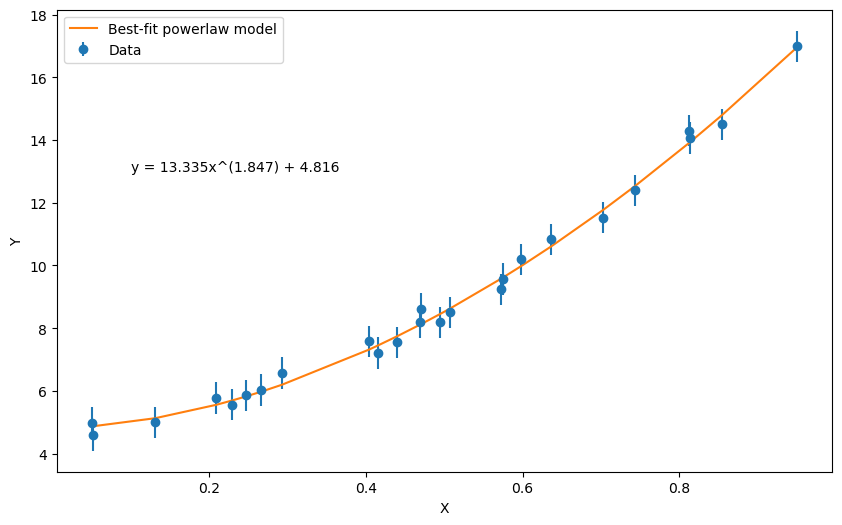

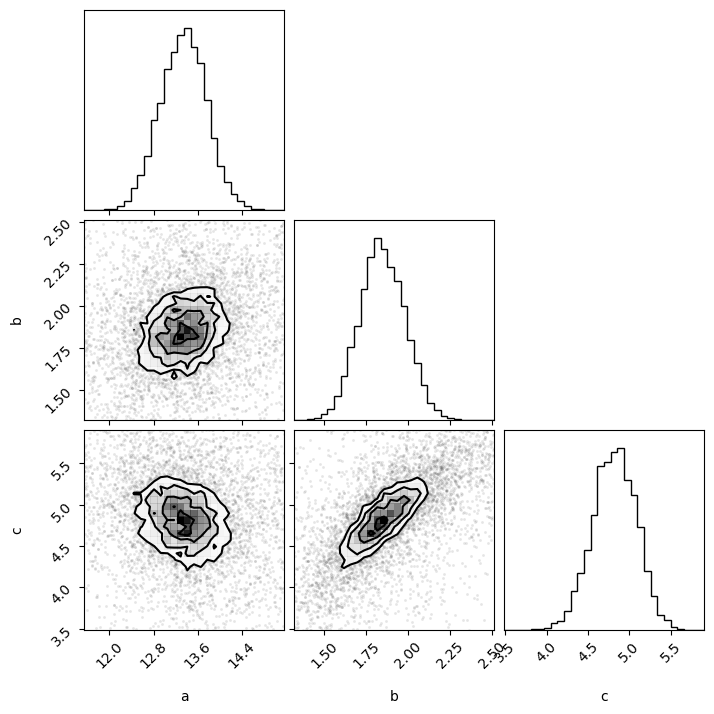

In [15]:


def loglike_powerlaw(theta):
    model = powerlaw(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_powerlaw = nestle.sample(loglike_powerlaw, prior, 3,npoints=1000, method='single')
print(result_powerlaw.summary(), f"\nlogzerr: {result_powerlaw.logzerr}")
p_powerlaw, cov_powerlaw = nestle.mean_and_cov(result_powerlaw.samples, result_powerlaw.weights)
print(f"Best-fit parameters: {p_powerlaw[0]:.3f} +/- {np.sqrt(cov_powerlaw[0,0]):.3f}")
print(f"Best-fit parameters: {p_powerlaw[1]:.3f} +/- {np.sqrt(cov_powerlaw[1,1]):.3f}")
print(f"Best-fit parameters: {p_powerlaw[2]:.3f} +/- {np.sqrt(cov_powerlaw[2,2]):.3f}")


plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, powerlaw(X, p_powerlaw), label='Best-fit powerlaw model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_powerlaw[0]:.3f}x^({p_powerlaw[1]:.3f}) + {p_powerlaw[2]:.3f}")
plt.legend()

fig = corner.corner(result_powerlaw.samples,weights=result_powerlaw.weights, labels=['a', 'b','c'],
                    range=[0.99999, 0.99999,0.99999], bins=30)
plt.show()
